# Model1 CNN+LSTM
version 0.1.b

## Implementation detals
- Input size: -1 x 2 x 90 x 33
- Bottleneck size: -1 x 36 x 19
- Output size: -1 x 128 x 128
<br></br>
- X: CSI (magnitude + phase)
- Y: masked depth image
## Version Info
- Mapping from CSI to depth images

In [1]:
# Imports
# !pip install torchinfo
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision
from torchinfo import summary
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import time

## Model

In [8]:
class MyEncodeCNN(nn.Module):
    def __init__(self):
        super(MyEncodeCNN, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=(3, 1), padding=0),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(inplace=True),
            # No Padding
            # No Pooling
            # In = 90 * 33 * 1
            # Out = 30 * 31 * 32
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=(1, 1), padding=0),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(inplace=True),
            # No Padding
            # No Pooling
            # In = 30 * 31 * 32
            # Out = 26 * 27 * 64
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=5, stride=(1, 1), padding=0),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(inplace=True),
            # No Padding
            # No Pooling
            # In = 26 * 27 * 64
            # Out = 22 * 23 * 32
        )

        self.layer4 = nn.Sequential(
            nn.Conv2d(32, 1, kernel_size=5, stride=(1, 1), padding=0),
            nn.BatchNorm2d(1),
            nn.LeakyReLU(inplace=True),
            # No Padding
            # No Pooling
            # In = 22 * 23 * 32
            # Out = 18 * 19 * 1
        )

        self.layerfc = nn.Sequential(
            nn.Linear(18*19, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 32)
        )

        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        # size_x = batch_size * 18 * 19
        # x = self.dropout(x)
        # x = self.layerfc(x)
        return x


class MyEncodeLSTM(nn.Module):
    def __init__(self):
        super(MyEncodeLSTM, self).__init__()

        self.hidden_size = 128
        self.num_layers = 2

        self.layer = nn.LSTM(36, self.hidden_size, self.num_layers, batch_first=True, dropout=0.1)

    def forward(self, x):
        out, (final_hidden_state, final_cell_state)  = self.layer(x)
        return out[:, None, -1, :]  


class MyEncoder(nn.Module):
    def __init__(self):
        super(MyEncoder, self).__init__()

        self.cnn1 = MyEncodeCNN()
        self.cnn2 = MyEncodeCNN()
        self.lstm = MyEncodeLSTM()

    def forward(self, x):
        x = torch.chunk(x, 2, dim=0)
        x1 = self.cnn1.forward(x[0].view(-1, 1, 90, 33))
        x2 = self.cnn2.forward(x[1].view(-1, 1, 90, 33))

        # size_x = batch_size * 18 * 19

        x = torch.cat([x1, x2], dim=2).transpose(1, 2).view(-1, 19, 36)
        # size_x = batch_size * 36  * 19

        x = self.lstm.forward(x)
        return x


class MyDecodeLSTM(nn.Module):
    def __init__(self):
        super(MyDecodeLSTM, self).__init__()

        self.hidden_size = 64
        self.num_layers = 2
        self.hidden = self.init_hidden()

        self.layer = nn.LSTM(128, self.hidden_size, self.num_layers, batch_first=True, dropout=0.1)

    def init_hidden(self):
        # Only for initialization
        return (torch.zeros(1, 1, self.hidden_size), torch.zeros(1, 1, self.hidden_size))

    def forward(self, x):
        out, (final_hidden_state, final_cell_state)  = self.layer(x)
        return out[:, -1, :]


class MyDecodeCNN(nn.Module):
    def __init__(self):
        super(MyDecodeCNN, self).__init__()

        self.layerfc = nn.Sequential(
            nn.Linear(64, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 256)
        )

        self.layer1 = nn.Sequential(
            nn.ConvTranspose2d(1, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(inplace=True),
            # No Unpooling
            # Upsample size by 2x2
            # In = 16 * 16 * 1
            # Out = 32 * 32 * 32
        )

        self.layer2 = nn.Sequential(
            nn.ConvTranspose2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(inplace=True),
            # No Unpooling
            # Upsample size by 2x2
            # In = 32 * 32 * 32
            # Out = 64 * 64 * 64
        )

        self.layer3 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(inplace=True),
            # No Unpooling
            # Upsample size by 2x2
            # In = 64 * 64 * 64
            # Out = 128 * 128 * 32
        )

        self.layer4 = nn.Sequential(
            nn.Conv2d(32, 1, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1),
            nn.LeakyReLU(inplace=True),
            # No Unpooling
            # Consistent size
            # In = 128 * 128 * 32
            # Out = 128 * 128 * 1
        )

        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.layerfc(x)
        x = self.dropout(x)
        x = self.layer1(x.view(-1, 1, 16, 16))
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        # size_x = batch_size * 200 * 120

        return x


class MyDecoder(nn.Module):
    def __init__(self):
        super(MyDecoder, self).__init__()

        self.lstm = MyDecodeLSTM()
        self.cnn = MyDecodeCNN()

    def forward(self, x):
        x = self.lstm.forward(x)

        # size_x = batch_size * 375, need batch_size * 25 * 15

        x = self.cnn.forward(x)
        return x


class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()

        self.encoder = MyEncoder()
        self.decoder = MyDecoder()

    def forward(self, x):
        z = self.encoder(x)
        y = self.decoder(z) 
        return y

In [9]:
m1 = MyModel()
summary(m1, input_size=(2, 90, 33))

Layer (type:depth-idx)                        Output Shape              Param #
MyModel                                       [1, 1, 128, 128]          --
├─MyEncoder: 1-1                              [1, 1, 128]               --
│    └─MyEncodeCNN: 2-1                       --                        48,032
│    │    └─Sequential: 3-1                   [1, 32, 30, 31]           384
│    │    └─Sequential: 3-2                   [1, 64, 26, 27]           51,392
│    │    └─Sequential: 3-3                   [1, 32, 22, 23]           51,296
│    │    └─Sequential: 3-4                   [1, 1, 18, 19]            803
│    └─MyEncodeCNN: 2-2                       --                        48,032
│    │    └─Sequential: 3-5                   [1, 32, 30, 31]           384
│    │    └─Sequential: 3-6                   [1, 64, 26, 27]           51,392
│    │    └─Sequential: 3-7                   [1, 32, 22, 23]           51,296
│    │    └─Sequential: 3-8                   [1, 1, 18, 19]        

## Dataset

In [10]:
datadir = '../Dataset/0124make00/'
print(os.listdir(datadir))

['t.npy', 'x.npy', 'y.npy']


In [11]:
# My Dataset

class MyDataset(Data.Dataset):
    def __init__(self, x_path, y_path, number=0):
        self.seeds = None
        self.data = self.load_data(x_path, y_path, number=number)
        print('loaded')

    def __getitem__(self, index):
        return self.data['x'][index], self.data['y'][index]

    def __len__(self):
        return self.data['x'].shape[0]

    def load_data(self, x_path, y_path, number):
        x = np.load(x_path)
        y = np.load(y_path)

        if x.shape[0] == y.shape[0]:
            total_count = x.shape[0]
        else:
            print(x.shape, y.shape, "lengths not equal!")
            
        if number != 0:
            picked = np.random.choice(list(range(total_count)), size=number, replace=False)
            self.seeds = picked
            x = x[picked]
            y = y[picked]

        return {'x':x, 'y':y}
    

mydata = MyDataset(datadir + 'x.npy', datadir + 'y.npy')

train_size = int(len(mydata) * 0.7)
valid_size = int(len(mydata) * 0.2)
test_size = int(len(mydata)) - train_size - valid_size
train_dataset, valid_dataset, test_dataset = Data.random_split(mydata, [train_size, valid_size, test_size])
print(train_size, valid_size, test_size)

train_loader = Data.DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = Data.DataLoader(valid_dataset, batch_size=64, shuffle=True)
test_loader = Data.DataLoader(test_dataset, batch_size=64, shuffle=True)

print(len(train_loader), len(valid_loader), len(test_loader))


loaded
4830 1380 690
76 22 11


In [12]:
print(mydata.data['x'].shape)
print(mydata.data['y'].shape)

(6900, 2, 90, 33)
(6900, 128, 128)


In [13]:
torch.cuda.get_device_name(0)

'GeForce GTX TITAN X'

## Running gears

In [14]:
# Hyperparameters

class MyArgs:
    def __init__(self, epochs=10, learning_rate=0.001):
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

args = MyArgs(epochs=1000, learning_rate=0.1)

In [25]:
# Model and Loss

model = MyModel().to(args.device)

criterion = torch.nn.SmoothL1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate)

train_loss = []
valid_loss = []
train_epochs_loss = []
valid_epochs_loss = []

# early_stopping = EarlyStopping(patience=args.patience,verbose=True)

In [26]:
# Training and Saving
start = time.time()

for epoch in range(args.epochs):
    model.train()
    train_epoch_loss = []
    for idx,(data_x,data_y) in enumerate(train_loader,0):
        data_x = data_x.to(torch.float32).to(args.device)
        data_y = data_y.to(torch.float32).to(args.device)
        outputs = model(data_x)
        loss = criterion(data_y, outputs)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_epoch_loss.append(loss.item())
        train_loss.append(loss.item())
        if idx%(len(train_loader)//2)==0:
            print("\repoch={}/{},{}/{}of train, loss={}".format(
            epoch, args.epochs, idx, len(train_loader),loss.item()), end='')
    train_epochs_loss.append(np.average(train_epoch_loss))
  
  #=====================valid============================
model.eval()
valid_epoch_loss = []
for idx,(data_x,data_y) in enumerate(valid_loader,0):
    data_x = data_x.to(torch.float32).to(args.device)
    data_y = data_y.to(torch.float32).to(args.device)
    outputs = model(data_x)
    loss = criterion(outputs,data_y)
    valid_epoch_loss.append(loss.item())
    valid_loss.append(loss.item())
valid_epochs_loss.append(np.average(valid_epoch_loss))

  #==================early stopping======================
  # early_stopping(valid_epochs_loss[-1],model=MyModel,path=r'')
  # if early_stopping.early_stop:
  #    print("Early stopping")
  #    break
  #====================adjust lr========================
lr_adjust = {
    2: 5e-5, 4: 1e-5, 6: 5e-6, 8: 1e-6,
    10: 5e-7, 15: 1e-7, 20: 5e-8
}
  #if epoch in lr_adjust.keys():
  #    lr = lr_adjust[epoch]
  #    for param_group in optimizer.param_groups:
  #        param_group['lr'] = lr
  #    print('Updating learning rate to {}'.format(lr))

torch.save(model.state_dict(), '../Models/v01b_ep1000.pth')
end = time.time()
print("\nTotal training time:", end-start, "sec")

/opt/conda/lib/python3.8/site-packages/torch/nn/modules/loss.py:907: UserWarning: Using a target size (torch.Size([64, 1, 128, 128])) that is different to the input size (torch.Size([64, 128, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


epoch=0/1000,38/76of train, loss=109.42947387695312

/opt/conda/lib/python3.8/site-packages/torch/nn/modules/loss.py:907: UserWarning: Using a target size (torch.Size([30, 1, 128, 128])) that is different to the input size (torch.Size([30, 128, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


epoch=999/1000,38/76of train, loss=119.46443176269531

/opt/conda/lib/python3.8/site-packages/torch/nn/modules/loss.py:907: UserWarning: Using a target size (torch.Size([64, 128, 128])) that is different to the input size (torch.Size([64, 1, 128, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)
/opt/conda/lib/python3.8/site-packages/torch/nn/modules/loss.py:907: UserWarning: Using a target size (torch.Size([36, 128, 128])) that is different to the input size (torch.Size([36, 1, 128, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)



Total training time: 7391.464342355728 sec


## Visualization of Training Process

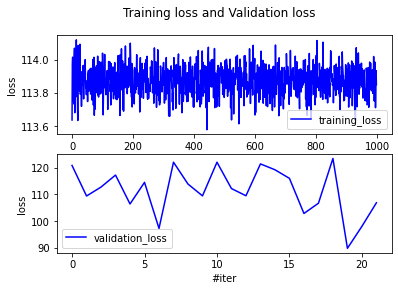

In [31]:
# Plot loss curves

%matplotlib inline
plt.clf()
plt.suptitle("Training loss and Validation loss")
plt.subplot(2, 1, 1)
plt.plot(train_epochs_loss[1:], 'b', label = 'training_loss')
plt.ylabel('loss')
plt.xlabel('#epoch')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(valid_loss, 'b', label = 'validation_loss')
plt.ylabel('loss')
plt.xlabel('#iter')
plt.legend()
#plt.savefig("loss_900epoch_down.jpg")

In [75]:
print(np.array(train_epochs_loss).shape, np.array(valid_epochs_loss).shape)
print(np.array(train_loss).shape, np.array(valid_loss).shape)

(70400,) (22,)
(352000,) (22,)


## Load from checkpoint

In [84]:
# If you want to train from a certain checkpoint

#model = torch.load('../Models/v0_ep500_lr001.pth')
model.load_state_dict(torch.load('../Models/v0_ep500_lr001.pth'))
model.cuda()

# Reload the loss curve
preserve = 500
# 3 iter per epoch
train_loss = train_loss[:preserve * 3]
# discard following epoch values
train_epochs_loss = train_epochs_loss[:preserve]

# re-validate
valid_loss = []
valid_epochs_loss = []

args = MyArgs(epochs=200, learning_rate=0.0001)

## Estimation
Few data

In [19]:
mydata_2 = MyDataset(datadir + 'x.npy', datadir + 'y.npy', number=14)
train_size2 = 10
valid_size2 = 2
test_size2 = 2
train_dataset2, valid_dataset2, test_dataset2 = Data.random_split(mydata_2, [train_size2, valid_size2, test_size2])
print(train_size2, valid_size2, test_size2)

train_loader2 = Data.DataLoader(train_dataset2, batch_size=2, shuffle=True)

print(len(train_loader2))

loaded
10 2 2
5


Ground Truth

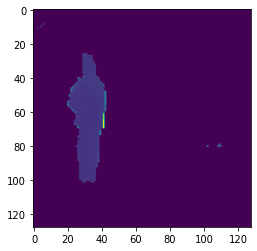

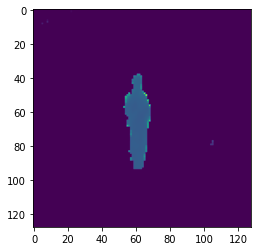

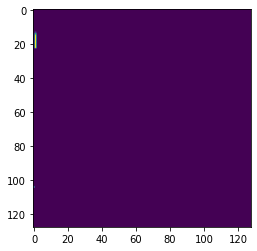

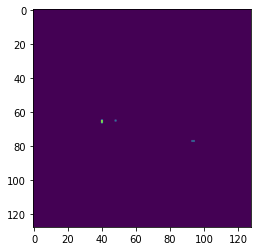

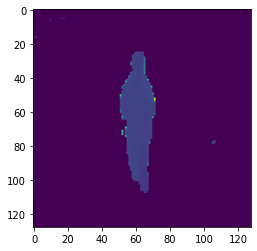

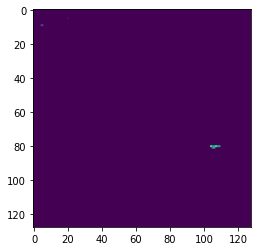

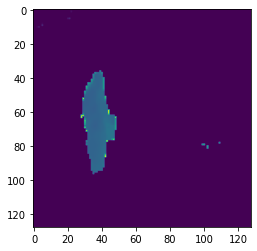

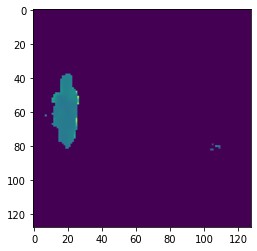

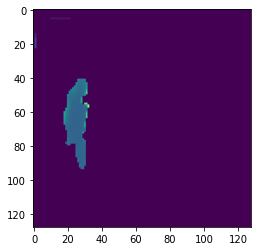

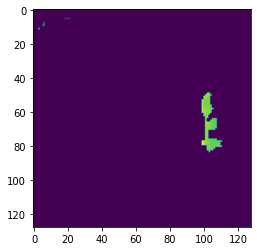

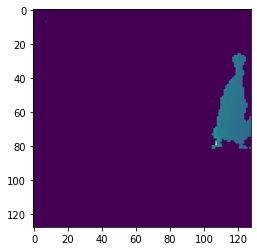

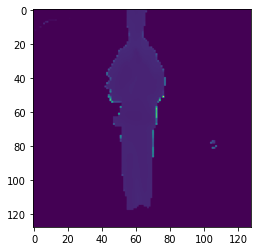

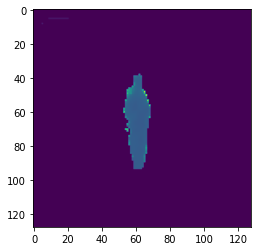

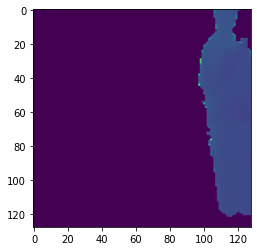

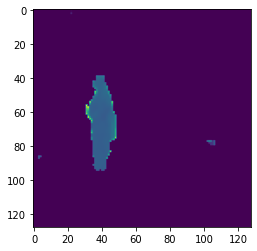

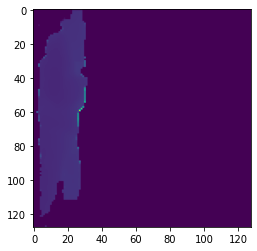

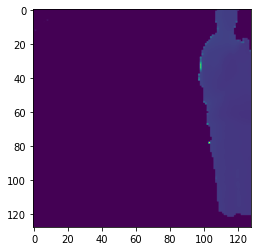

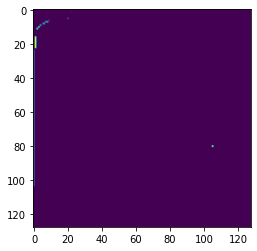

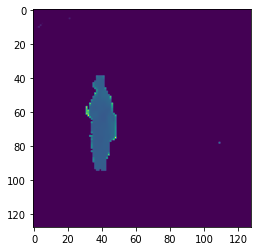

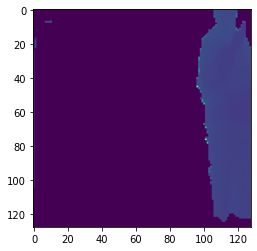

In [22]:
%matplotlib inline
csis = np.zeros((10,2,90,33))
for i in range(10):
    plt.figure()
    plt.imshow(next(iter(train_loader))[1][0, :, :].numpy())
    plt.show()
    plt.figure()
    plt.imshow(next(iter(train_loader))[1][1, :, :].numpy())
    plt.show()
    csis[i]=next(iter(train_loader))[0][0, ...].numpy()

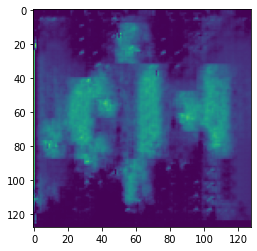

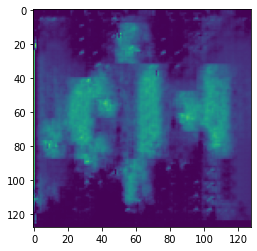

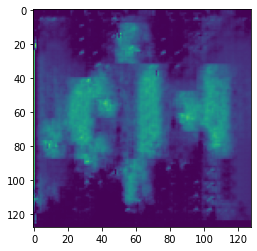

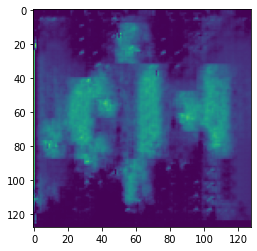

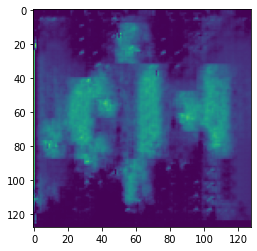

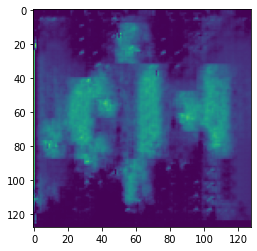

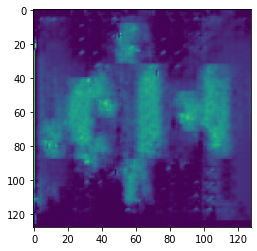

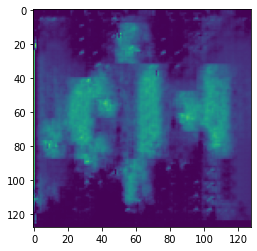

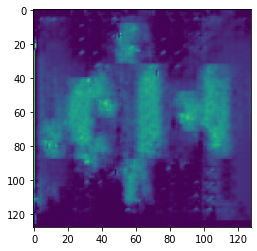

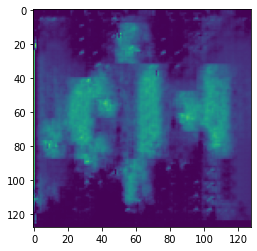

In [32]:
%matplotlib inline
data = torch.tensor(csis, dtype=torch.float32, device='cuda:1')
for i in range(len(data)):
    predictions = model(data[i])
    pred = predictions.cpu().detach().numpy()[0, 0]
    plt.figure()
    plt.imshow(pred)
    plt.show()